In [53]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from collections import deque

from tqdm import tqdm

In [76]:
class box_with_particles:
    def __init__(self, dt = 0.1, t_stop = 2.5, box_length = [1,1], number_of_particles = 1) -> None:

        self.dt = dt
        self.t_stop = t_stop
        self.time_list = np.arange(0, t_stop, dt)
        self.number_of_time_steps = len(self.time_list)
        self.box_length = box_length
        self.number_of_particles = number_of_particles

        self.x_list = np.zeros( ( len(self.time_list), self.number_of_particles ))
        self.y_list = np.zeros( ( len(self.time_list), self.number_of_particles ))

        self.vx_list = np.zeros( ( len(self.time_list), self.number_of_particles ))
        self.vy_list = np.zeros( ( len(self.time_list), self.number_of_particles ))

        self.current_it = 0

        return

    def set_initial_positions(self, initial_positions_x, initial_positions_y):
        for i in range(self.number_of_particles):
            self.x_list[0, i] = initial_positions_x[i]
            self.y_list[0, i] = initial_positions_y[i]
        return

    def set_initial_positions_random(self):
        for i in range(self.number_of_particles):
            x = np.random.rand()
            y = np.random.rand()
            self.x_list[0, i] = x
            self.y_list[0, i] = y
        return
    
    def set_initial_velocities(self, initial_velocities_x, initial_velocities_y):
        for i in range(self.number_of_particles):
            self.vx_list[0, i] = initial_velocities_x[i]
            self.vy_list[0, i] = initial_velocities_y[i]
        return
    
    def set_initial_velocities_random(self):
        for i in range(self.number_of_particles):
            v_theta = np.random.rand() * 2*np.pi
            vx = np.cos(v_theta)
            vy = np.sin(v_theta)
            self.vx_list[0, i] = vx
            self.vy_list[0, i] = vy
        return
    
    def prepare_simulation_random(self):
        self.set_initial_positions_random()
        self.set_initial_velocities_random()
        return

    def make_time_step(self):
        self.current_it += 1
        it = self.current_it
        for i in range(self.number_of_particles):
            vx = self.vx_list[it-1, i]
            vy = self.vy_list[it-1, i]
            self.x_list[it, i] = self.x_list[it-1, i] + vx*self.dt
            self.y_list[it, i] = self.y_list[it-1, i] + vy*self.dt

            # Update velocity
            self.vx_list[it, i] = vx
            self.vy_list[it, i] = vy

        return

    def run_simulation(self):
        for step in tqdm( range(self.number_of_time_steps-1) ):
            self.make_time_step()
        return
    
    def prepare_figure(self):
        fig = plt.figure(figsize=(5, 4))

        L_x = self.box_length[0]
        L_y = self.box_length[1]

        ax = fig.add_subplot(autoscale_on=False, xlim=(0, L_x), ylim=(0, L_y))
        ax.set_aspect('equal')

        self.fig = fig
        self.ax = ax
        ax.grid()

        line, = self.ax.plot([], [], 'o', lw=2)
        time_template = 'time = %.1fs'
        time_text = self.ax.text(0.05, 0.9, '', transform=ax.transAxes)

        self.line = line
        self.time_template = time_template
        self.time_text = time_text
        return
    
    def animate(self, this_it):
        this_x = []
        this_y = []
        for i in range( self.number_of_particles ):
            this_x.append( self.x_list[this_it, i] )
            this_y.append( self.y_list[this_it, i] )

        self.line.set_data(this_x, this_y)
        self.time_text.set_text(self.time_template % (this_it*self.dt))
        return self.line, self.time_text
    
    def create_animation(self):
        self.prepare_figure()

        ani = animation.FuncAnimation(
            self.fig, self.animate, self.number_of_time_steps, interval=self.dt*1000, blit=True)

        writer = PillowWriter(fps=24)
        ani.save('animation.gif', writer='imagemagick')  # Save as GIF
        plt.show()

In [81]:
simulation = box_with_particles(dt = 0.1, t_stop = 2.5, box_length = [3,2], number_of_particles = 2)
simulation.prepare_simulation_random()
simulation.run_simulation()

100%|██████████| 24/24 [00:00<00:00, 43804.74it/s]


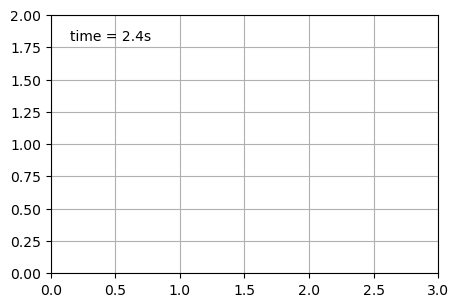

In [82]:
simulation.create_animation()